<a href="https://colab.research.google.com/github/harperd/machine-learning/blob/master/clustering-kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

https://www.datascience.com/blog/k-means-clustering

Clustering, in Machine Learning, is the assignment of a set of *observations* into subsets (called *clusters*) so that observations in the same cluster are similar in some sense. Clustering is a method of *unsupervised learning*, meaning, we don't know what the actual outomes may be or should be. Clustering is an optimization problem. We need to identify the best cluster of *features* unlike *supervised learning* where we are given *labeled data* where we need to identify the mathematical service that best separates the labeled examples. K-Means clustering, however, is subject to constraints to avoid overfitting.

![](https://github.com/harperd/machine-learning/blob/master/images/kmeans.png?raw=1)

## When to Use K-Means

* Useful when the number of necessary clusters (k) is known.
* Monitoring a tracked data point to see if it switches between groups over time can be used to detect meaningful changes in the data.

## The Alogrithm

*K-Means* is an unsupervised machine learning algorithm (data is labeled) that groups a dataset into a user-specified number of clusters. The algorithm uses iterative refinement to produce a final result of identified k clusters. Meaning, it continually seeks to find k number of *centriods* (centers or mean data points) with each iteration as it runs. The basic logic for K-Means is:

1. Randomly choose k examples as initial centroids
2. For each centroid, create k clusters by assigning each example to the closest centroid.
3. Compute k new centroids by averaging examples in each cluster.
4. Continue until centroids don’t change.

## Clustering Constraints

Learned models (clusters) will depend on certain constraints:

- The distance metric between examples (Minkowski + Linkage) **See also:** [Cluster Distance](https://github.com/harperd/machine-learning/blob/master/cluster-distance.ipynb)
- Which Features to include
- Constraints on the complexity of the model to avoid overfitting (each Example is its own cluster):
- The specified number of clusters *k*

# Import Python Packages

In [0]:
# Save our graph results in our notebook
%matplotlib inline

# NumPy adds support for large, multi-dimensional arrays and matrices, along with a large collection 
# of high-level mathematical functions to operate on these arrays.
import numpy as np

# Matplotlib is a plotting library for the Python programming language and its numerical mathematics 
# extension NumPy. It provides an object-oriented API for embedding plots into applications using 
# general-purpose GUI toolkits like Tkinter, wxPython, Qt, or GTK+.
import matplotlib.pyplot as plt

# Pandas is a software library for data manipulation and analysis. In particular, it offers data 
# structures and operations for manipulating numerical tables and time series.
import pandas as pd

# For K-Means clustering
from sklearn.cluster import KMeans

# Data visualization using a Pandas Scatter Matrix
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

# Import The Data

In [148]:
df_raw = pd.read_csv(
    'https://raw.githubusercontent.com/harperd/machine-learning/master/data/cardiacData.csv',
    #'https://raw.githubusercontent.com/harperd/machine-learning/master/data/delivery-fleet-driver-data.csv',
    #sep='\t',
    header = None,
    #names = [ 'Driver_ID', 'Distance_Feature', 'Speeding_Feature'], 
    names = ['a','b','c','d','e'],
    low_memory = False)
%time print(f"{len(df_raw.index)} rows read.")
df_raw = df_raw.drop('e', axis = 1)

250 rows read.
CPU times: user 80 µs, sys: 48 µs, total: 128 µs
Wall time: 133 µs


In [0]:
df_raw.head()

,Driver_ID,Distance_Feature,Speeding_Feature
0,3423311935,71.24,28.0
1,3423313212,52.53,25.0
2,3423313724,64.54,27.0
3,3423311373,55.69,22.0
4,3423310999,54.58,25.0


# Understanding Our Data

**See also:** [Data Visualization Notebook](https://github.com/harperd/machine-learning/data-visualization.ipynb)

All data types are numeric so there is no need to create categories for any of the features (i.e. convert to numeric).

In [0]:
df_raw.dtypes

Driver_ID             int64
Distance_Feature    float64
Speeding_Feature    float64
dtype: object

The *Driver_ID* feature looks to have a larger magnatidue and range thatn the rest of the features. This could lead to a "noisy" dataset.

In [0]:
df_raw.describe(include='all')

,Driver_ID,Distance_Feature,Speeding_Feature
count,4.000000e+03,4000.000000,4000.000000
mean,3.423312e+09,76.041523,10.721000
std,1.154845e+03,53.469563,13.708543
min,3.423310e+09,15.520000,0.000000
25%,3.423311e+09,45.247500,4.000000
50%,3.423312e+09,53.330000,6.000000
75%,3.423313e+09,65.632500,9.000000
max,3.423314e+09,244.790000,100.000000


# Visualizing Our Data

**See also:** [Data Visualization Notebook](https://github.com/harperd/machine-learning/data-visualization.ipynb)

As suspected, the data does not represent a normal or *Gaussian* distribution. However, there seems to be some relationship between *Distance_Feature* and *Speeding_Feature*.

Function show_scatter_matrix() created.


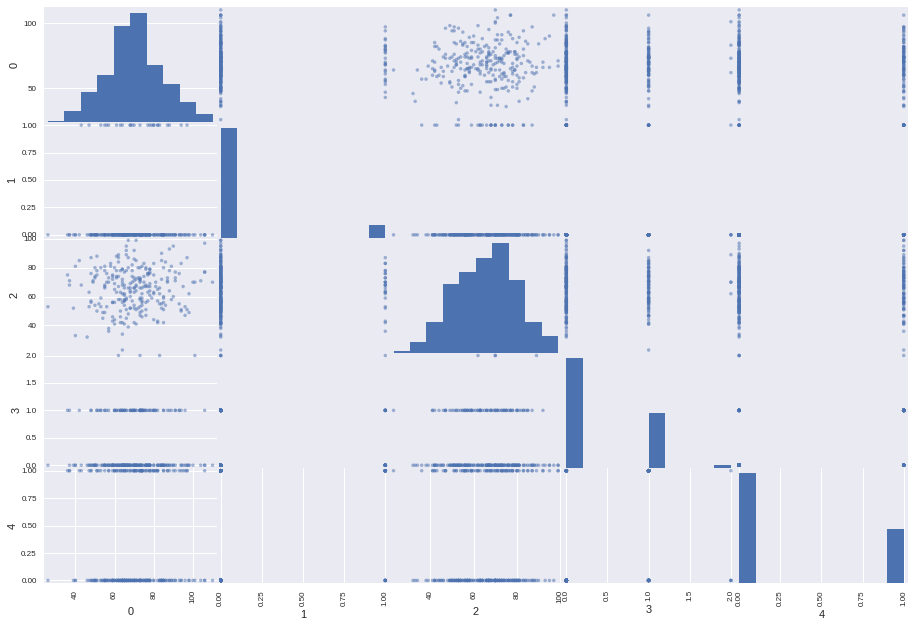

In [143]:
def show_scatter_matrix(df):
    scatter_matrix(df)
    plt.subplots_adjust(left = 0, right = 2, top = 3, bottom = 1, wspace = None, hspace = None)
    plt.show()
    
print("Function show_scatter_matrix() created.")

show_scatter_matrix(df_raw)

As suspected the data is a bit "noisy" with no pattern of circular clusters. The data tends to cluster at the bottom and top.

Function show_scatter_plot() created.


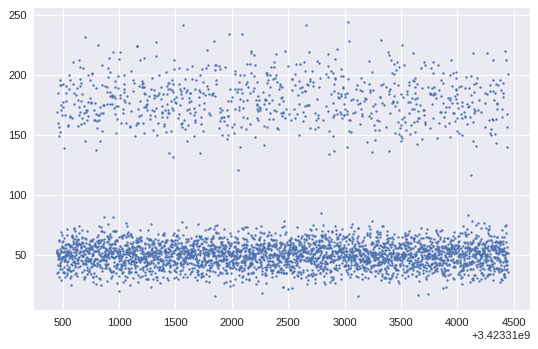

In [5]:
def show_scatter_plot(df, predictor = None):
    plt.figure(figsize=(8, 5), dpi=80)
    X = df.values
        
    if (predictor == None):
        plt.scatter(X[:, 0], X[:, 1], s=3);
    else:
        y_kmeans = predictor
        plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=3, cmap='viridis')
        centers = predictor.cluster_centers_
        plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
    
print("Function show_scatter_plot() created.")

show_scatter_plot(df_raw)

# Feature Engineering

Since *Driver_ID* was suspect, and not really needed in this data set anyway, let's remove it. Plotting the data set with *Driver_ID* removed now reveals a better distribution of points.

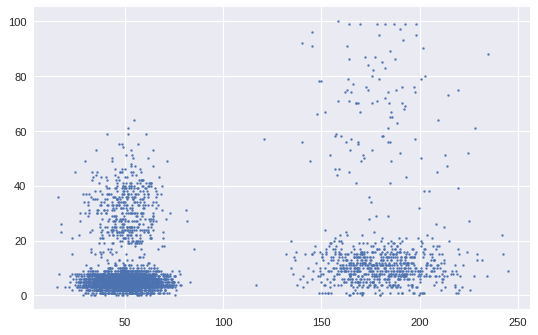

In [6]:
df_fixed = df_raw.drop('Driver_ID', axis = 1)

show_scatter_plot(df_fixed)

Same for the scatter matrix...

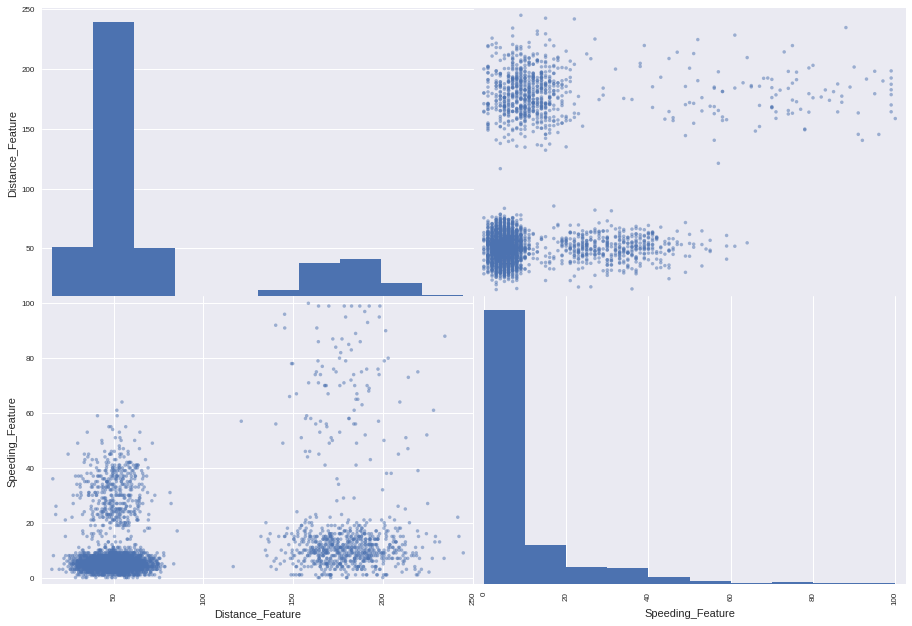

In [9]:
show_scatter_matrix(df_fixed)

## Choosing K

The K-Means algorithm is somewhat naive as it clusters the data into a user specified k clusters, even if k is not the right number of clusters to use. Therefore, it is sometimes a challenge to find the optimal value for k. An optimial k is one where increasing k doesn't give much better model of the data.

There are different ways to choose a number of clusters (k) such as have a priori knowledge about the application domain. But that is more than likely not the case in the real world. You can use hierarchical clustering on a subset of data where each leaf node in a tree is a cluster but this is slow on larger datasets and not an optimal way of choosing a value for k. Other more common ways are outlined in detail in the following sections.

Things to consider when choosing K:

* Results can depend on location of initial centroids.
* Choosing the wrong k value can lead to inaccurate results.
* Hyperparameters may need to be tuned to get a better model fit.

In [51]:
# Function for K-Means clustering used in the following sections.
def cluster_kmeans(df, k):
    predictor = KMeans(
        #
        # KMeans Hyperparameters
        #
        
        # The number of clusters to form as well as the number of centroids to generate.
        n_clusters = k, 
        # Method for initialization, defaults to ‘k-means++’:
        # ‘k-means++’: selects initial cluster centers for k-mean clustering in a smart way to 
        #              speed up convergence.
        # ‘random’: choose k observations (rows) at random from data for the initial centroids.
        init = 'k-means++',
        # Maximum number of iterations of the k-means algorithm for a single run.
        max_iter = 300,
        # Number of time the k-means algorithm will be run with different centroid seeds. 
        # The final results will be the best output of n_init consecutive runs in terms of inertia.
        n_init = 10,
        # Determines random number generation for centroid initialization. Use an int to 
        # make the randomness deterministic. 
        random_state = 0)

    # Compute k-means clustering.
    predictor.fit(df)
 
    return predictor
 
print("Function cluster_kmeans() created.")

Function cluster_kmeans() created.


### Method 1: Measuring Model Optimization

One way to find an optimal value for k is int trying different values of k and evaluate quality of results (dissimilarity).


**Cluster Variability** is the sum of the distance between the cluster mean (centroid) and each example then square the result. A low value denotes a tight cluster. 'c' denotes a single cluster and 'e' denotes a single vector within the cluster.

   ![](https://github.com/harperd/machine-learning/blob/master/images/variability.jpg?raw=1)

**Model Dissimilarity** is the sum of all the cluster variabilities. High model dissimilarities result in an underfit model so constraints need to be applied as “guardrails” to provide a more fit model such as fewer clusters (k) or some feature values need to be scaled. 'c' denotes a single cluster, 'C' denotes all clusters or the model and 'e' denotes a single vector within the cluster.

Overfitting and underfitting are the two biggest causes for poor performance of machine learning algorithms. Ideally, you want to select a model at the sweet spot between underfitting and overfitting.

   ![](https://github.com/harperd/machine-learning/blob/master/images/dissimilarity.jpg?raw=1)

#### Cluster Variability

To measture the dissimilarity of the model *C* we need to first create a function that will measure the variaiblity of a single cluster. We will use Euclidean Distance as it is more common.

In [111]:
import scipy.spatial.distance as dist

def variability(cluster, centroid):
    v = 0
    
    for e in cluster:
         v = v + ( dist.euclidean(centroid, e) ** 2 )
        
    return v
  
print("Function variability() created.")

Function variability() created.


#### Model Dissimilarity

Now that we have a function to measture the variaiblity of each cluster we can then employ that function to measure the dissimilarity of our model.

In [157]:
def print_dissimilarity(predictor):
  centroids = predictor.cluster_centers_
  k = len(centroids)
  d = 0
print(k)
  for cluster_index in range(0, k-1):
    centroid = centroids[cluster_index]
    cluster = np.where(predictor.labels_ == cluster_index)[0]
    
    v =  variability(cluster, centroid)
    d = d + v
    
    print(f"Cluster {cluster_index}: Size = {len(cluster)}, Variability = {v}")

  print(f"Dissimilarity = {d}")
  print()

print("Function print_dissimilarity() created.")

IndentationError: ignored

**What are we looking for?** We want to identify the k value just before the dissimilarity value starts showing our model is starting to underfit. Too low of a value means the model is overfit. A good k value is somewhere in the middle. Using the below as an example, we would choose a k of 3.

> ```
Model dissimilarity with k = 1 is 4.53787
Model dissimilarity with k = 2 is 3.53491
Model dissimilarity with k = 3 is 3.63242
Model dissimilarity with k = 4 is 3.89453
Model dissimilarity with k = 5 is 4.14325
```

In [158]:
# k values we what to try
samples = 10

for k in range(1, samples):
    predictor = cluster_kmeans(df_raw, k)
    print_dissimilarity(predictor)

Cluster 0: Size = 250, Variability = 14540705.196000002
Cluster 0: Size = 250, Variability = 14540705.196000002
Dissimilarity = 29081410.392000005

Cluster 0: Size = 118, Variability = 6110373.694915255
Cluster 1: Size = 132, Variability = 8492097.477272727
Dissimilarity = 14602471.17218798

Cluster 0: Size = 90, Variability = 4940733.555555556
Cluster 2: Size = 81, Variability = 4752907.296296296
Dissimilarity = 9693640.85185185

Cluster 0: Size = 42, Variability = 2392595.6666666665
Cluster 3: Size = 75, Variability = 4396259.56
Dissimilarity = 6788855.226666667

Cluster 0: Size = 80, Variability = 4572986.074999999
Cluster 4: Size = 50, Variability = 2840700.7399999998
Dissimilarity = 7413686.8149999995

Cluster 0: Size = 26, Variability = 1683869.346153846
Cluster 5: Size = 44, Variability = 2415487.409090909
Dissimilarity = 4099356.755244755

Cluster 0: Size = 29, Variability = 1429624.4137931035
Cluster 6: Size = 26, Variability = 1580751.653846154
Dissimilarity = 3010376.0676392

If you will node the dissimilarity of a model (predictor) with one cluster (k = 1) is zero. This because each point is in

###  Method 2: Elbow Method (Sum of Squared Errors)

This method looks at the percentage of variance explained as a function of the number of clusters. Achieving this yeilds and optimal value for k. The idea of the elbow method is to run K-Means clustering on the dataset for a range of values of k (k from 1 to 10 for example). Then, for each value of k, calculate the *Sum of Squared Errors (SSE)* or *Within Cluster Sum of Squares (WCSS)*. The smaller the SSE the better and the SSE tends to decrease toward 0 as we increase k. When SSE is 0 then k is equal to the number of data points (or *Examples*) in the dataset. This is because each data point is its own cluster (*Over Fitting*), and there is no error between it and the center of its cluster.

**What are we looking for?** The goal is to choose a small value of k that still has a low SSE. The elbow usually represents where we start to have diminishing returns by increasing k. In the example below, a k of 3 is the optimal number.

![](https://github.com/harperd/machine-learning/blob/master/images/elbow-method.png?raw=1)

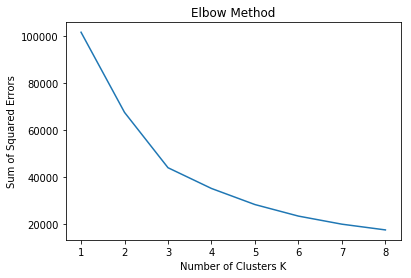

In [0]:
sse = []
samples = 9

# Try different values for k and record the results.
for k in range(1, samples):
    model = cluster_kmeans(df_raw, k)
    # interia_ is the sum of squared distances of samples 
    # to their closest cluster center.
    sse.append(model.inertia_)
    
# Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, samples), sse)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters K')
plt.ylabel('Sum of Squared Errors')
plt.show()

### Method 3: Average Silhouette Method

*Silhouette Analysis* can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) are:

- **Near +1** indicate that the sample is far away from the neighboring clusters.
- **0** indicates that the sample is on or very close to the decision boundary between two neighboring clusters.
- **Negative values** indicate that those samples might have been assigned to the wrong cluster.

When k = 2 the average silhouette_score is: 0.3021807114941397
When k = 3 the average silhouette_score is: 0.3467030401711417
When k = 4 the average silhouette_score is: 0.3284735173910422
When k = 5 the average silhouette_score is: 0.33432817044493063
When k = 6 the average silhouette_score is: 0.335372235286428
When k = 7 the average silhouette_score is: 0.3390782723367
When k = 8 the average silhouette_score is: 0.34906365821387497
When k = 9 the average silhouette_score is: 0.34277569399268565


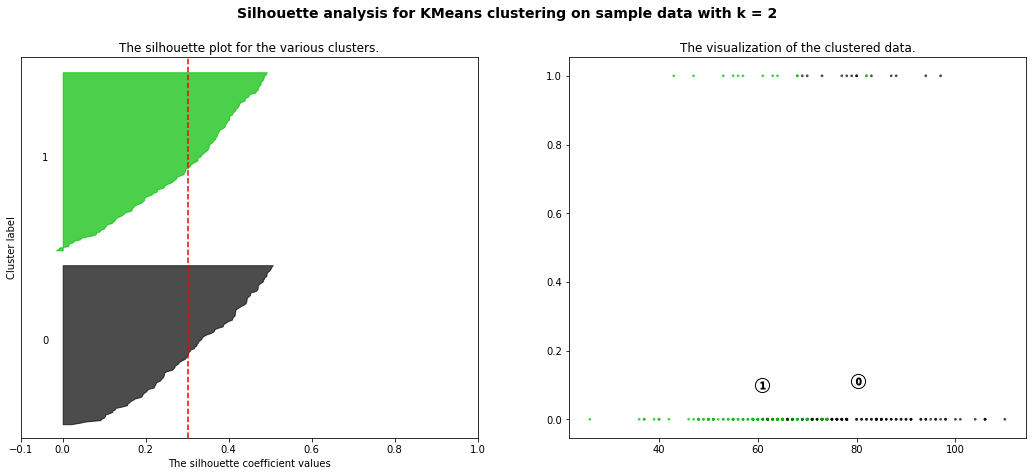

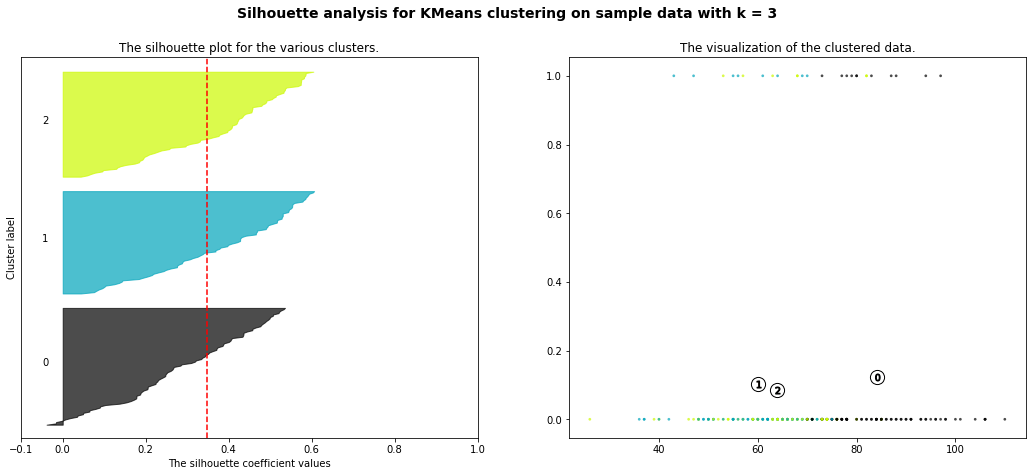

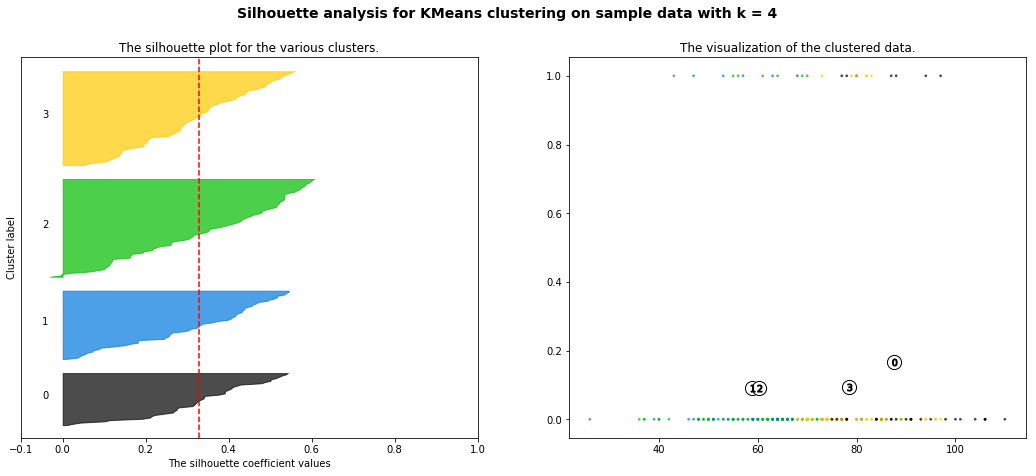

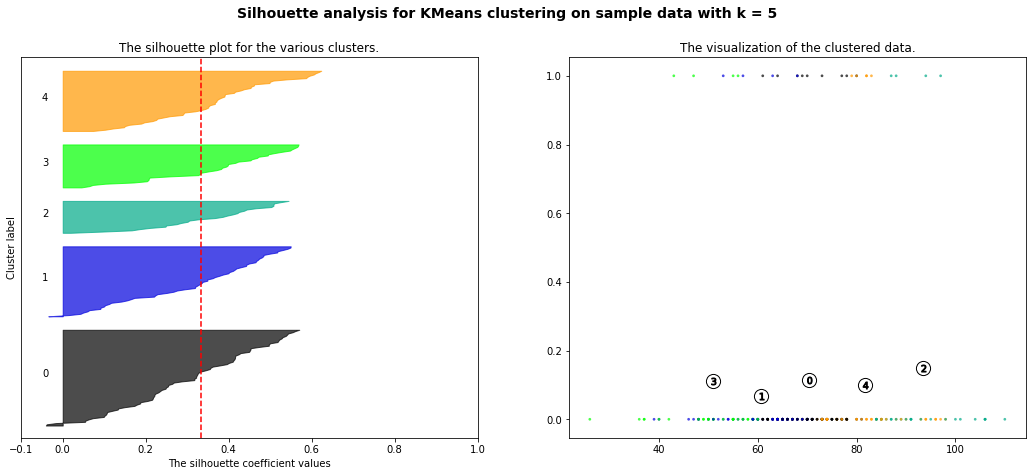

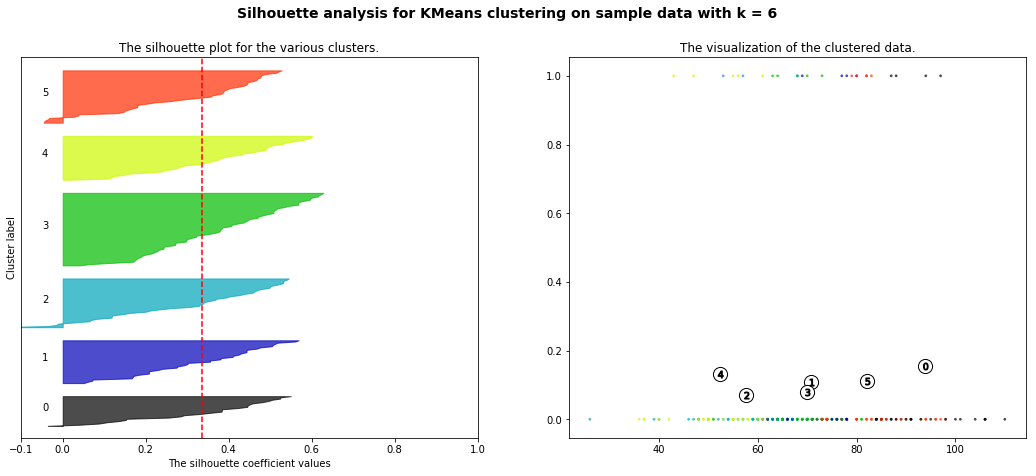

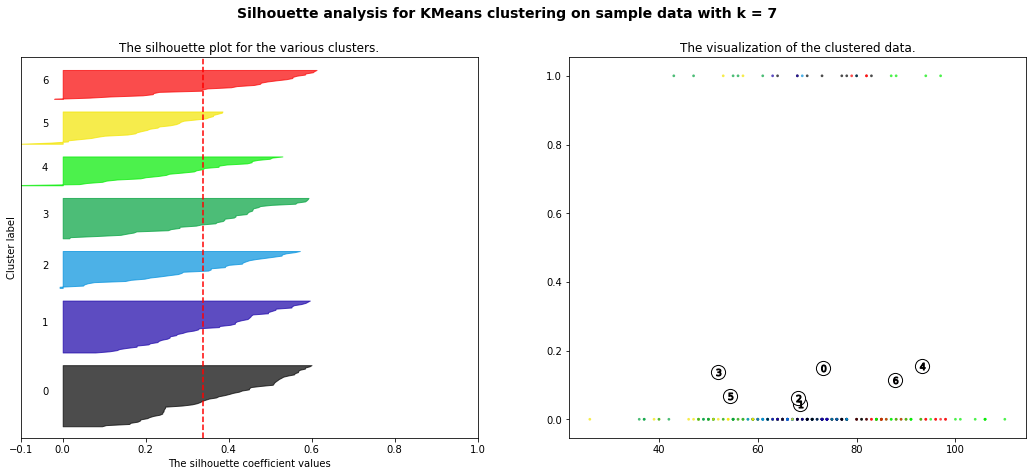

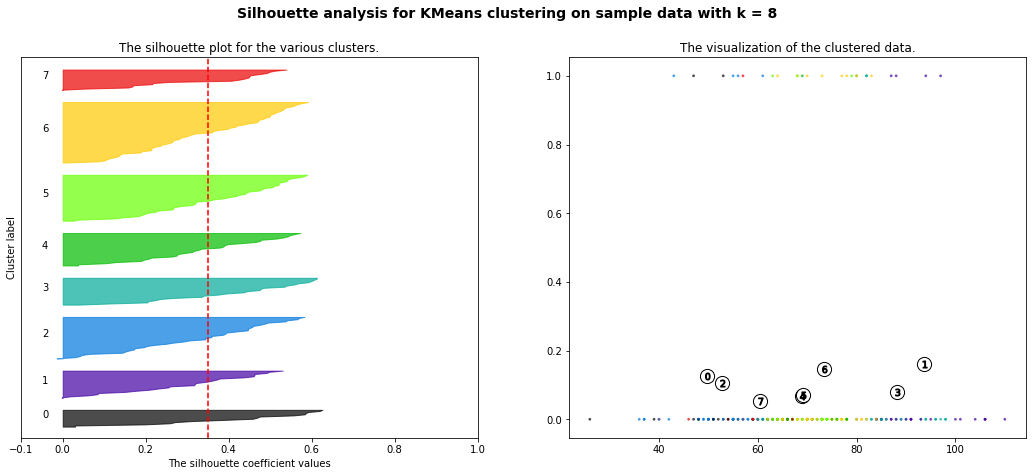

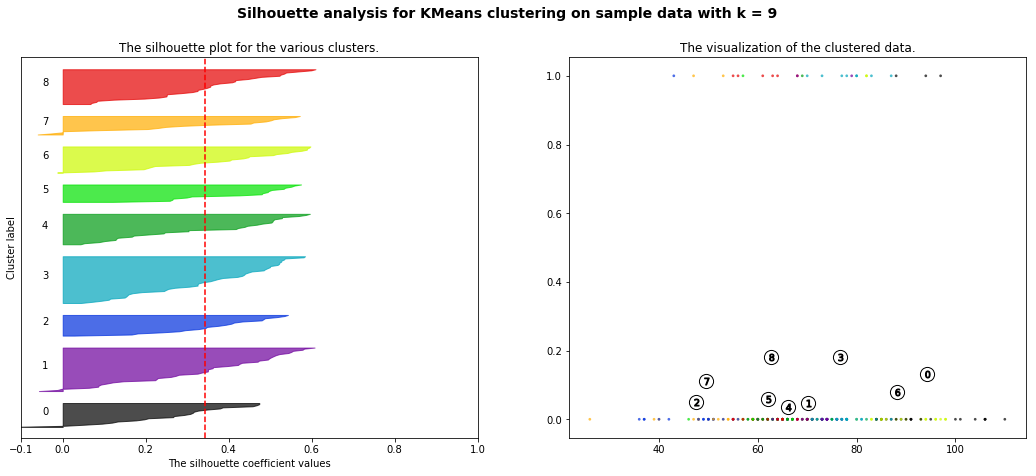

In [0]:
from __future__ import print_function
#print(__doc__)

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

X = df_raw.values
samples = 10

for k in range(2, samples):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    
    # The (k+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (k + 1) * 10])

    # Initialize the model with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    model = cluster_kmeans(df_raw, k)
    cluster_labels = model.predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters.
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f'When k = {k} the average silhouette_score is: {silhouette_avg}')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor = color, edgecolor = color, alpha = 0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title('The silhouette plot for the various clusters.')
    ax1.set_xlabel('The silhouette coefficient values')
    ax1.set_ylabel('Cluster label')

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x = silhouette_avg, color = 'red', linestyle = '--')

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(X[:, 0], X[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7,
                c = colors, edgecolor = 'k')

    # Labeling the clusters
    centers = model.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker = 'o',
                c = 'white', alpha = 1, s = 200, edgecolor = 'k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker = '$%d$' % i, alpha = 1,
                    s = 50, edgecolor = 'k')

    ax2.set_title('The visualization of the clustered data.')
    # ax2.set_xlabel('Feature space for the 1st feature')
    # ax2.set_ylabel('Feature space for the 2nd feature')

    plt.suptitle(('Silhouette analysis for KMeans clustering on sample data '
                  'with k = %d' % k),
                 fontsize = 14, fontweight = 'bold')

plt.show()

### Method 4: Gap Statistic Method

### Method 5: G-Means Algorithm

# Creating The Cluster

Now that we have a good value for k we can go ahead and create our model.

In [0]:
%time model = cluster_kmeans(df_raw, k = 3)

Wall time: 38.5 ms
